In [39]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable
from tqdm.auto import tqdm

In [40]:
args = {
      'ckptpath': './HW9-parameter/checkpoint.pth',
      'dataset_dir': './data/food/'
}
args = argparse.Namespace(**args)

In [41]:
# Model definition
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        def building_block(indim, outdim):
            return [
                nn.Conv2d(indim, outdim, 3, 1, 1),
                nn.BatchNorm2d(outdim),
                nn.ReLU(),
              ]
        def stack_blocks(indim, outdim, block_num):
            layers = building_block(indim, outdim)
            for i in range(block_num - 1):
                layers += building_block(outdim, outdim)
            layers.append(nn.MaxPool2d(2, 2, 0))
            return layers

        cnn_list = []
        cnn_list += stack_blocks(3, 128, 3)
        cnn_list += stack_blocks(128, 128, 3)
        cnn_list += stack_blocks(128, 256, 3)
        cnn_list += stack_blocks(256, 512, 1)
        cnn_list += stack_blocks(512, 512, 1)
        self.cnn = nn.Sequential( * cnn_list)

        dnn_list = [
          nn.Linear(512 * 4 * 4, 1024),
          nn.ReLU(),
          nn.Dropout(p = 0.3),
          nn.Linear(1024, 11),
        ]
        self.fc = nn.Sequential( * dnn_list)

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fc(out)

In [42]:
# It might take some time, if it is too long, try to reload it.
# Dataset definition
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # pytorch dataset class
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# help to get data path and label
def get_paths_labels(path):
    def my_key(name):
          return int(name.replace(".jpg","").split("_")[1])+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(args.dataset_dir)

train_set = FoodDataset(train_paths, train_labels, mode='eval')

In [43]:
# Load trained model
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# It should display: <All keys matched successfully> 

<All keys matched successfully>

tensor([0, 1, 1, 2, 2, 3, 5, 6, 8, 9])


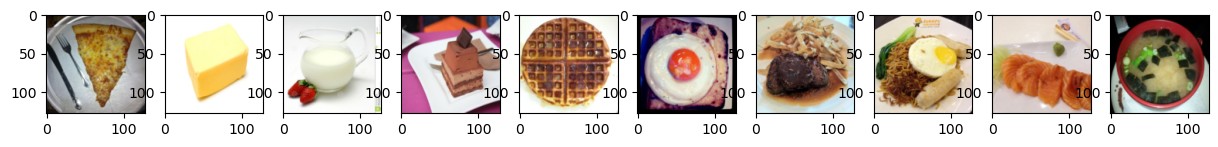

In [50]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
print(labels)
# this line can help you know the labels of each image

## Lime

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


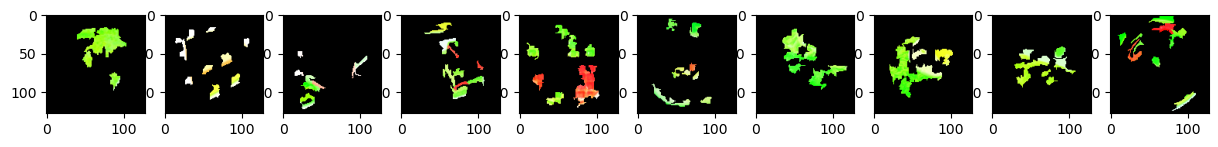

In [49]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=400, compactness=1, sigma=1, start_label=1)                                                                                                              
                                                                                                                                                                             

fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))                                                                                                                                                                 
# fix the random seed to make it reproducible
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=True,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.1                                                                                                                            
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

## Saliency Map 

In [80]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())
    # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # we want the gradient of the input x
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

#     saliencies = x.grad.abs().detach().cpu()
    saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

    # We need to normalize each image, because their gradients might vary in scale
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

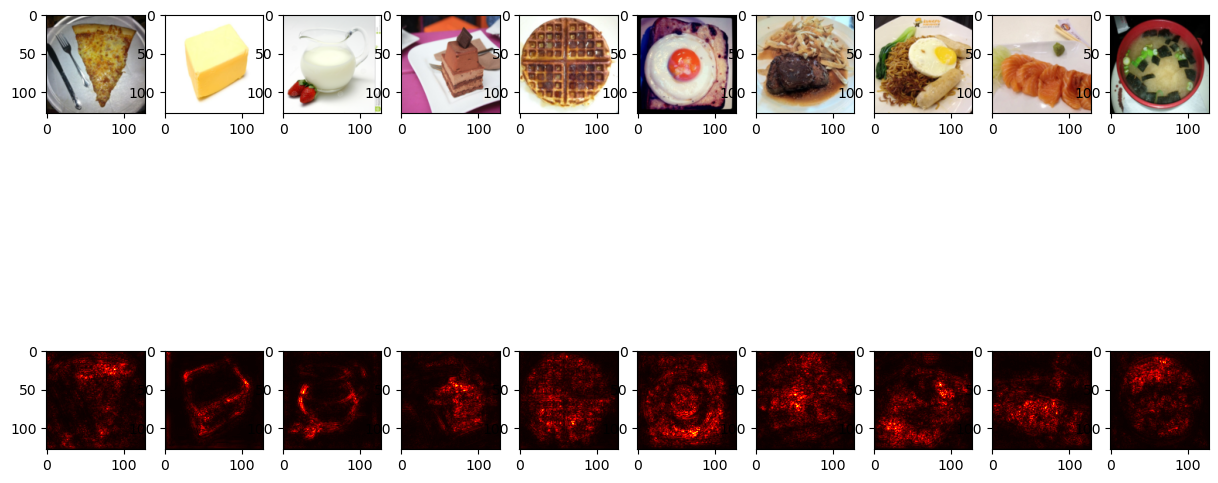

In [82]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        if row==0:
            axs[row][column].imshow(img.permute(1, 2, 0).numpy())
        else:
            axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)

plt.show()
plt.close()

## Smooth Grad

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

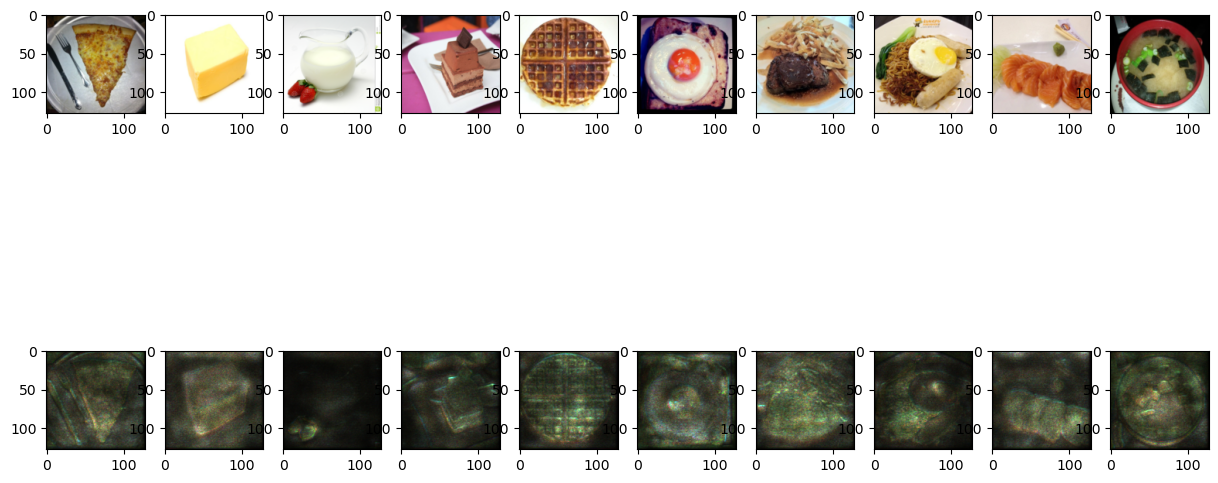

In [84]:
# Smooth grad

def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
    model.eval()
    #x = x.cuda().unsqueeze(0)

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
    smooth = np.zeros(x.cuda().unsqueeze(0).size())
    
    for i in tqdm(range(epoch)):
        # call Variable to generate random noise
        noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
        x_mod = (x+noise).unsqueeze(0).cuda()
        x_mod.requires_grad_()

        y_pred = model(x_mod)
        loss_func = torch.nn.CrossEntropyLoss()
        loss = loss_func(y_pred, y.cuda().unsqueeze(0))
        loss.backward()

    # like the method in saliency map
        smooth += x_mod.grad.abs().detach().cpu().data.numpy()
    smooth = normalize(smooth / epoch) # don't forget to normalize
#     smooth = smooth / epoch # try this line to answer the question
    return smooth

# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
    smooth.append(smooth_grad(i, l, model, 50, 0.4))
smooth = np.stack(smooth)
# print(smooth.shape)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, smooth]):
    for column, img in enumerate(target):
        axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)))

## Filter Explanation

In [32]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
    # x: input image
    # cnnid: cnn layer id
    # filterid: which filter
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
  
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # When the model forwards through the layer[cnnid], it needs to call the hook function first
    # The hook function save the output of the layer[cnnid]
    # After forwarding, we'll have the loss and the layer activation

    # Filter activation: x passing the filter will generate the activation map
    model(x.cuda()) # forward

    # Based on the filterid given by the function argument, pick up the specific filter's activation map
    # We just need to plot it, so we can detach from graph and save as cpu tensor
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

    # Filter visualization: find the image that can activate the filter the most
    x = x.cuda()
    x.requires_grad_()
    # input image gradient
    optimizer = Adam([x], lr=lr)
    # Use optimizer to modify the input image to amplify filter activation
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)
    
        objective = -layer_activations[:, filterid, :, :].sum()
        # We want to maximize the filter activation's summation
        # So we add a negative sign

        objective.backward()
        # Calculate the partial differential value of filter activation to input image
        optimizer.step()
    # Modify input image to maximize filter activation
    filter_visualizations = x.detach().cpu().squeeze()

    # Don't forget to remove the hook
    hook_handle.remove()
    # The hook will exist after the model register it, so you have to remove it after used
    # Just register a new hook if you want to use it

    return filter_activations, filter_visualizations

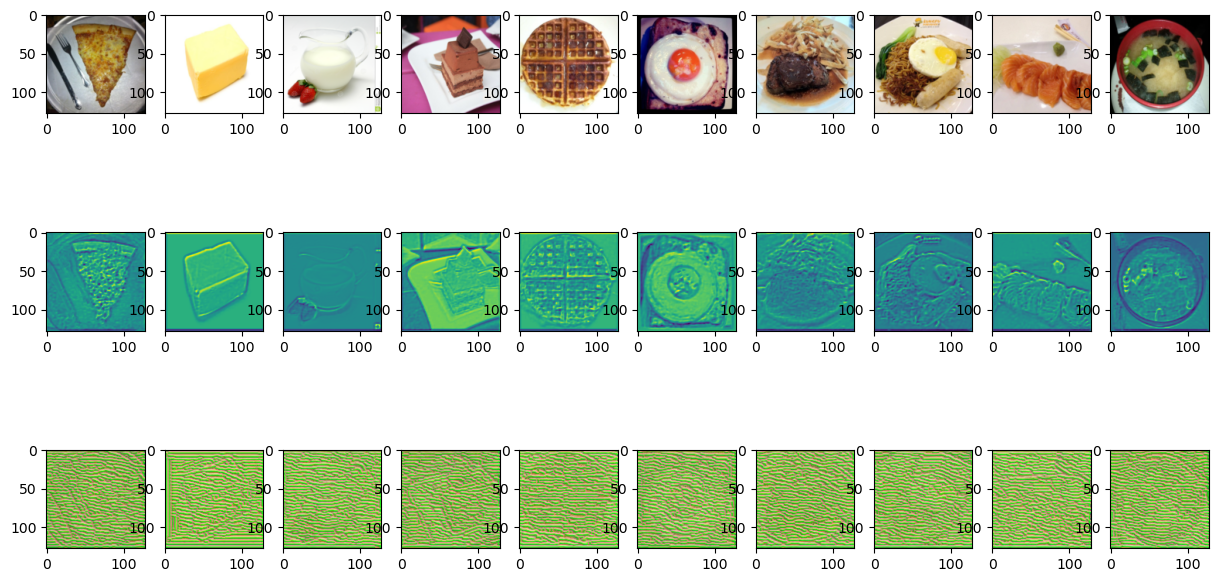

In [97]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=6, filterid=50, iteration=100, lr=0.1)

fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()

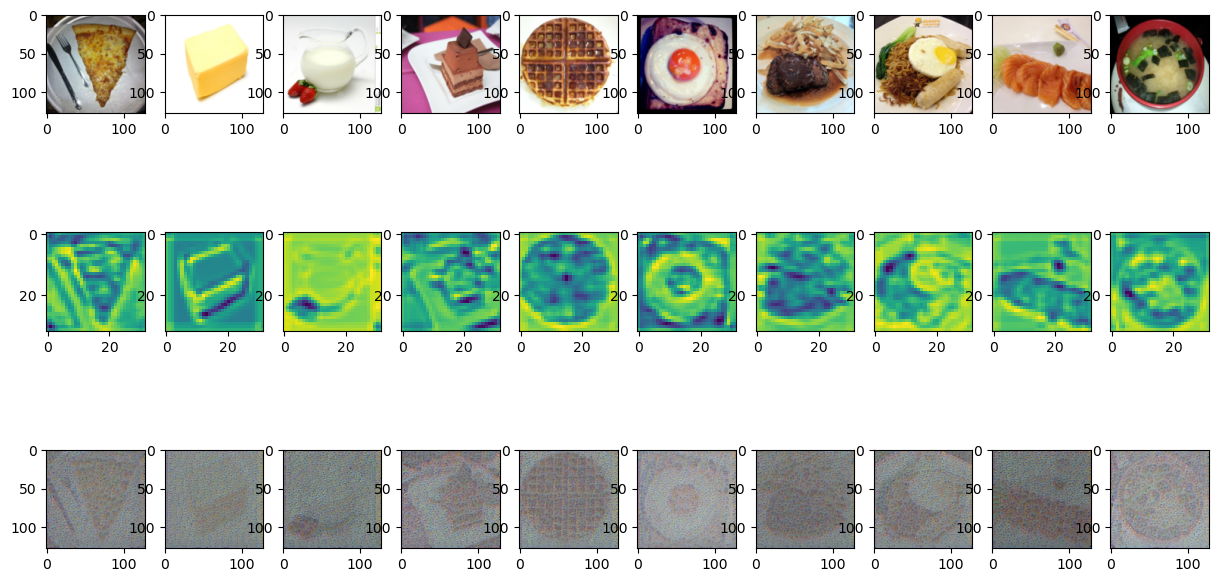

In [34]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=23, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


## Integrated Gradients 

In [35]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an image composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
      return (image - image.min()) / (image.max() - image.min())

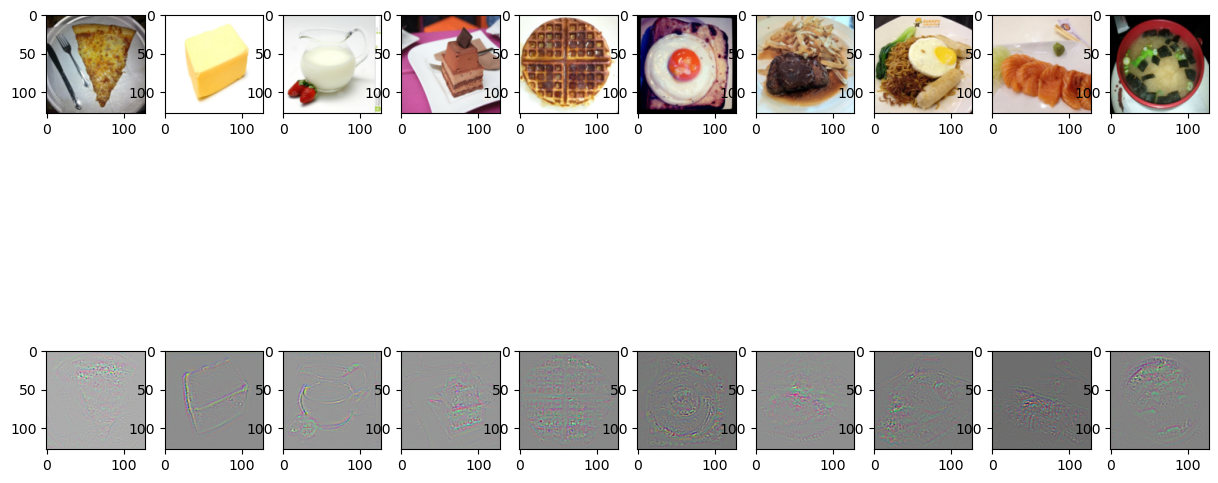

In [36]:
# put the image to cuda
images, labels = train_set.getbatch(img_indices)
images = images.cuda()

IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
    img = img.unsqueeze(0)
    integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 10))
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
    axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()